## Run this notebook in Google Colab by clicking here: [Google Colab](https://colab.research.google.com/github/AaronDJohnson/12p5yr_stochastic_analysis/blob/master/tutorials/sngl_psr_wn.ipynb)

### Run these cells if using Colab. Otherwise, skip them!

In [ ]:
# This cell will reset the kernel.
# Run this cell, wait until it's done, then run the next.
!pip install -q condacolab
import condacolab
condacolab.install_mambaforge()

In [ ]:
%%capture
!mamba install -y -c conda-forge enterprise_extensions la_forge
!git clone https://github.com/AaronDJohnson/12p5yr_stochastic_analysis
import sys
sys.path.insert(0,'/content/12p5yr_stochastic_analysis/tutorials')

# Using enterprise to analyze PTA data

In this notebook you will learn:
* How to use `enterprise` to interact with NANOGrav data,
* How to setup an analysis of individual pulsar white noise properties,
* How to post-process your results.

* White noise consists of equal power at all frequencies.
* In NANOGrav, white noise enters our data through the radio telescopes which consists of measurement noise from
  * Backend, receiver combinations
  * correlations between TOAs that are taken close together in time.
* There are two terms that we add into models:
  * `MeasurementNoise` or `EFAC` which is ideally close to 1
  * `EQUAD` or an extra noise term added in quadrature
  * and `ECORR` which should take care of correlations between TOAs that are close together in time.

* We run a single pulsar noise run on all pulsars before doing the full GWB search which will be covered in other files.
* The resulting maximum posterior values get put into a noise file to be used with the full search

# Load packages and modules

In [1]:
%%capture
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import sys
IN_COLAB = 'google.colab' in sys.modules

import os, glob
import matplotlib.pyplot as plt
import numpy as np

from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals import white_signals
from enterprise.signals import gp_signals

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

## Get par, tim, and noise files

In [2]:
psrlist = None # define a list of pulsar name strings that can be used to filter.
if IN_COLAB:
    datadir = '/content/12p5yr_stochastic_analysis/tutorials/data'
else:
    datadir = './data'

In [3]:
psrstring = 'J1853+1303'  # name of the pulsar

parfiles = sorted(glob.glob(os.path.join(os.path.join(datadir, 'par'), psrstring + '*')))
timfiles = sorted(glob.glob(os.path.join(os.path.join(datadir, 'tim'), psrstring + '*')))

# filter
if psrlist is not None:
    parfiles = [x for x in parfiles if x.split('/')[-1].split('.')[0] in psrlist]
    timfiles = [x for x in timfiles if x.split('/')[-1].split('.')[0] in psrlist]

# Make sure you use the tempo2 parfile for J1713+0747!!
# ...filtering out the tempo parfile... 
parfiles = [x for x in parfiles if 'J1713+0747_NANOGrav_12yv3.gls.par' not in x]

In [4]:
# if these are empty, then your data directory is wrong.
print(parfiles)
print(timfiles)

['./data/par/J1853+1303_NANOGrav_12yv3.gls.par']
['./data/tim/J1853+1303_NANOGrav_12yv3.tim']


## Load into `Pulsar` class list

* The `enterprise` Pulsar class uses `libstempo` to read in `par` and `tim` files, then stores all pulsar data into a `Pulsar` object. This object contains all data and meta-data needed for the ensuing pulsar and PTA analysis. You no longer need to reference the `par` and `tim` files after this cell.
* Note below that you can explicitly declare which version of the JPL solar-system ephemeris model that will be used to compute the Roemer delay between the geocenter and the barycenter (e.g. `DE438`). Otherwise the default values will be taken from the `par` files. Explicitly declaring the version here is good practice.
* You can also explicitly set the clock file to a version of `BIPM`, e.g. `BIPM(2018)`. This is less important, and you can let the code take the value from the `par` file.
* When you execute the following cell, you will get warnings like `WARNING: Could not find pulsar distance for PSR ...`. Don't worry! This is expected, and fine. Not all pulsars have well constrained distances, and will be set to `1 kpc` with a `20%` uncertainty.

### Read par and tim files into `enterprise` `Pulsar` objects

In [5]:
psrs = []
for p, t in zip(parfiles, timfiles):
    if psrstring in p:
        psr = Pulsar(p, t, ephem='DE438', clk='BIPM(2018)')
        psrs.append(psr)

[tempo2Util.C:396] Warning: [MISC1] Unknown parameter in par file:  DMX
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.

[tempo2Util.C:396] Warning: [PAR2] Have not set a DM epoch. The period epoch will be used instead. ../par/J1853+1303_NANOGrav_12yv3.gls.par
[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[observatory.C:272] Warning: Assuming site '3' means 'ao'


# Single pulsar noise analysis
* `enterprise` is structured so that one first creates `parameters`, then `signals` that these `parameters` belong to, then finally a `model` that is the union of all `signals` and the `data`.
* We will show this explicitly below, then introduce some model shortcut code that will make model specification faster.
* We test on `J1853+1303`.

In [6]:
psr = [p for p in psrs if p.name == 'J1853+1303'][0]

In [7]:
# find the maximum time span to set red-noise/DM-variation frequency sampling
tmin = psr.toas.min()
tmax = psr.toas.max()
Tspan = np.max(tmax) - np.min(tmin)
print(Tspan / 365.25 / 24 / 60 / 60)  # time span of data in years

5.979596068858798


In [8]:
# define selection by observing backend
# there will be separate white noise parameters for each observing backend
# since NANOGrav began taking data, there have been two generations of backends
# (ASP and PUPPI at Arecibo, GASP and GUPPI at Green Bank)
selection = selections.Selection(selections.by_backend)

## Create parameters
* White noise parameters are varied for each pulsar and then set to their maximum posterior values when running the analyses for the entire array.
* These parameters are saved as a dictionary to a `.json` noisefile or set of noisefiles for easy access.
* Here we go through what one of these white noise searches looks like in long form, and then we will use shortcuts to do the same thing.

### Priors

* First, we set a `Uniform` prior on the each of the white noise parameters and the intrinsic red noise parameters for the pulsar.

In [9]:
# white noise parameters
efac = parameter.Uniform(0.01, 10.0)
tnequad = parameter.Uniform(-8.5, -5)
ecorr = parameter.Uniform(-8.5, -5)

# red noise parameters
log10_A = parameter.Uniform(-20, -11)
gamma = parameter.Uniform(0, 7)

### Create signals
* Next, we attach the priors above to the signal models.
* Setting `selections.by_backend` sorts TOAs by backend/receiver combinations.
* The signal models will search over each of these sets of TOAs for these white noise signals.

In [10]:
# white noise
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.TNEquadNoise(log10_tnequad=tnequad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30, Tspan=Tspan)

# timing model
tm = gp_signals.TimingModel(use_svd=True)  # stabilizing timing model design matrix with SVD

### Piece the full model together
* Adding each of the signals together and instantiating a `PTA` object returns the full model.

In [11]:
# full model
s = tm + ef + eq + ec + rn

In [12]:
# intialize a single-pulsar pta model
# see how the "model" acts on the "pulsar" object...
pta = signal_base.PTA(s(psr))

## Get ready to sample

### Setup the sampler
* We use PTMCMCSampler to sample the posterior distribution.
* The sampler uses a parallel tempered, Metropolis-Hastings algorithm to propose moves in the parameter space
* We won't use the parallel tempering part of the sampler here

In [13]:
# draw initial sample from the priors
x0 = np.hstack([p.sample() for p in pta.params])
ndim = len(x0)

* PTMCMCSampler offers a convenient method for us to tell it which parameters we expect to be correlated: sampling groups
* By adding a sampling group, we tell PTMCMCSampler to propose moves to points in each of these groups.

In [14]:
all_params = np.arange(ndim)
groups = []
print(groups)

[]


In [15]:
# initial sample covariance matrix
cov = np.diag(np.ones(ndim))

# where chains will be written to
if IN_COLAB:
    outdir = '/content/12p5yr_stochastic_analysis/tutorials/chains/sngl_wn'
else:
    outdir = './chains/sngl_wn/'

# sampler object
sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov,
                 outDir=outdir, resume=False)

## Sample

* You can sample this yourself, or you can use the chains that we have provided.

In [16]:
chain = np.load(outdir + '/chain_1.npz')['arr_0']

In [17]:
# sampler for N steps
N = int(5e6)

# SCAM = Single Component Adaptive Metropolis
# AM = Adaptive Metropolis
# DE = Differential Evolution
## You can keep all these set at default values
# uncomment the following to sample
# sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

## Simple post-processing

In [18]:
# uncomment this line if you sampled yourself:
# chain = np.loadtxt(outDir + '/chain_1.txt')

# this line will load the chains that we have provided:
chain = np.load(outdir + '/chain_1.npz')['arr_0']

burn = int(0.1 * chain.shape[0])

In [19]:
ind = pta.param_names.index('J1853+1303_red_noise_log10_A')

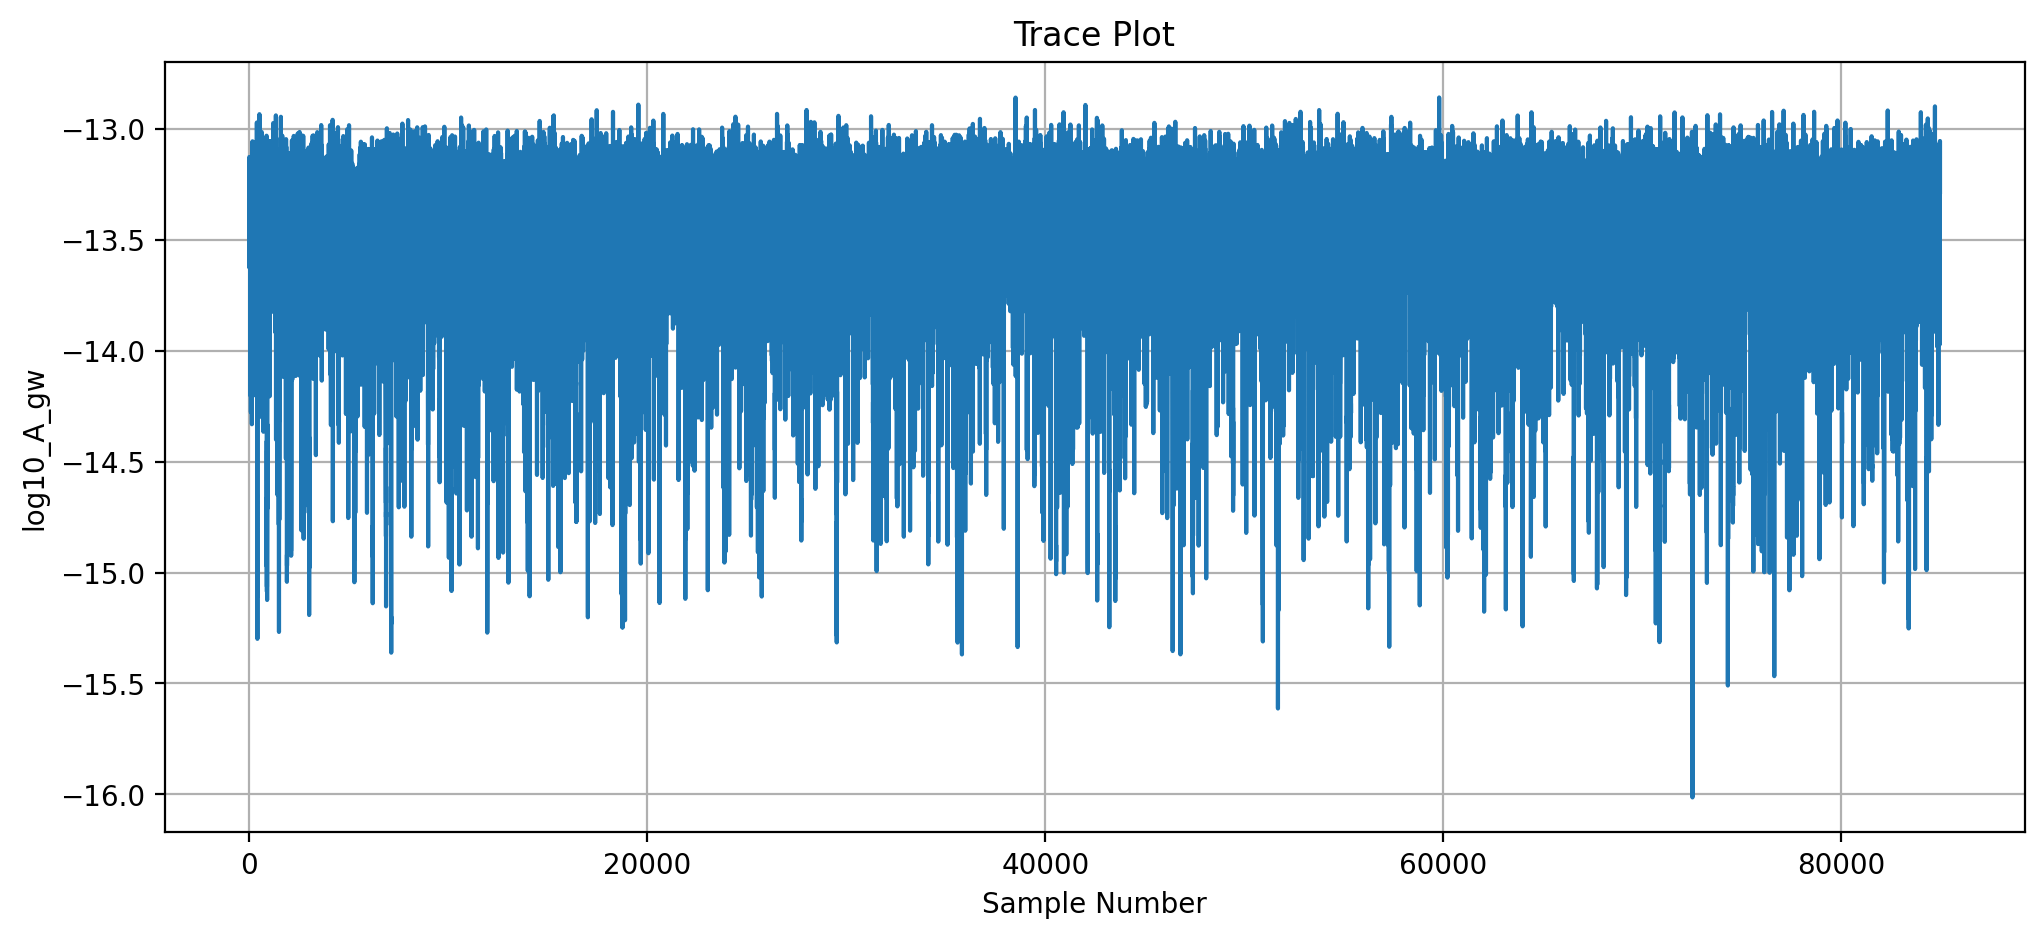

In [20]:
# Make trace-plot to diagnose sampling
plt.figure(figsize=(12, 5))
plt.plot(chain[burn:, ind])
plt.xlabel('Sample Number')
plt.ylabel('log10_A_gw')
plt.title('Trace Plot')
plt.grid(visible=True)
plt.show()

* A well sampled chain should look more like a **fuzzy** caterpillar than a **skinny worm**.
* This one appears to be pretty well sampled.

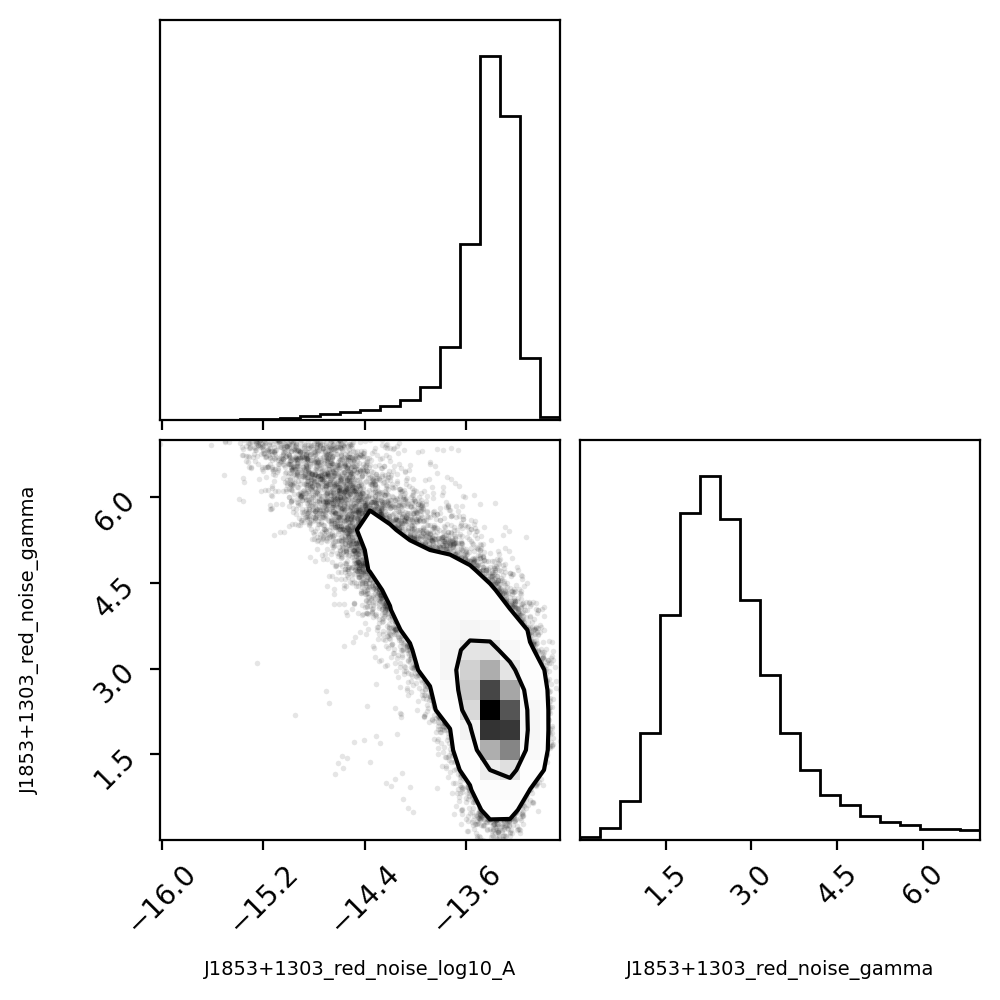

In [21]:
# Make 2d histogram plot for red noise
ind_redA = list(pta.param_names).index(psrstring + '_red_noise_log10_A')
ind_redgam = list(pta.param_names).index(psrstring + '_red_noise_gamma')
fig = corner.corner(chain[burn:, [ind_redA, ind_redgam]], 
                    labels=[psrstring + '_red_noise_log10_A',
                            psrstring + '_red_noise_gamma'],
                            label_kwargs={"fontsize": 7},
                            levels=[0.68,0.95]);

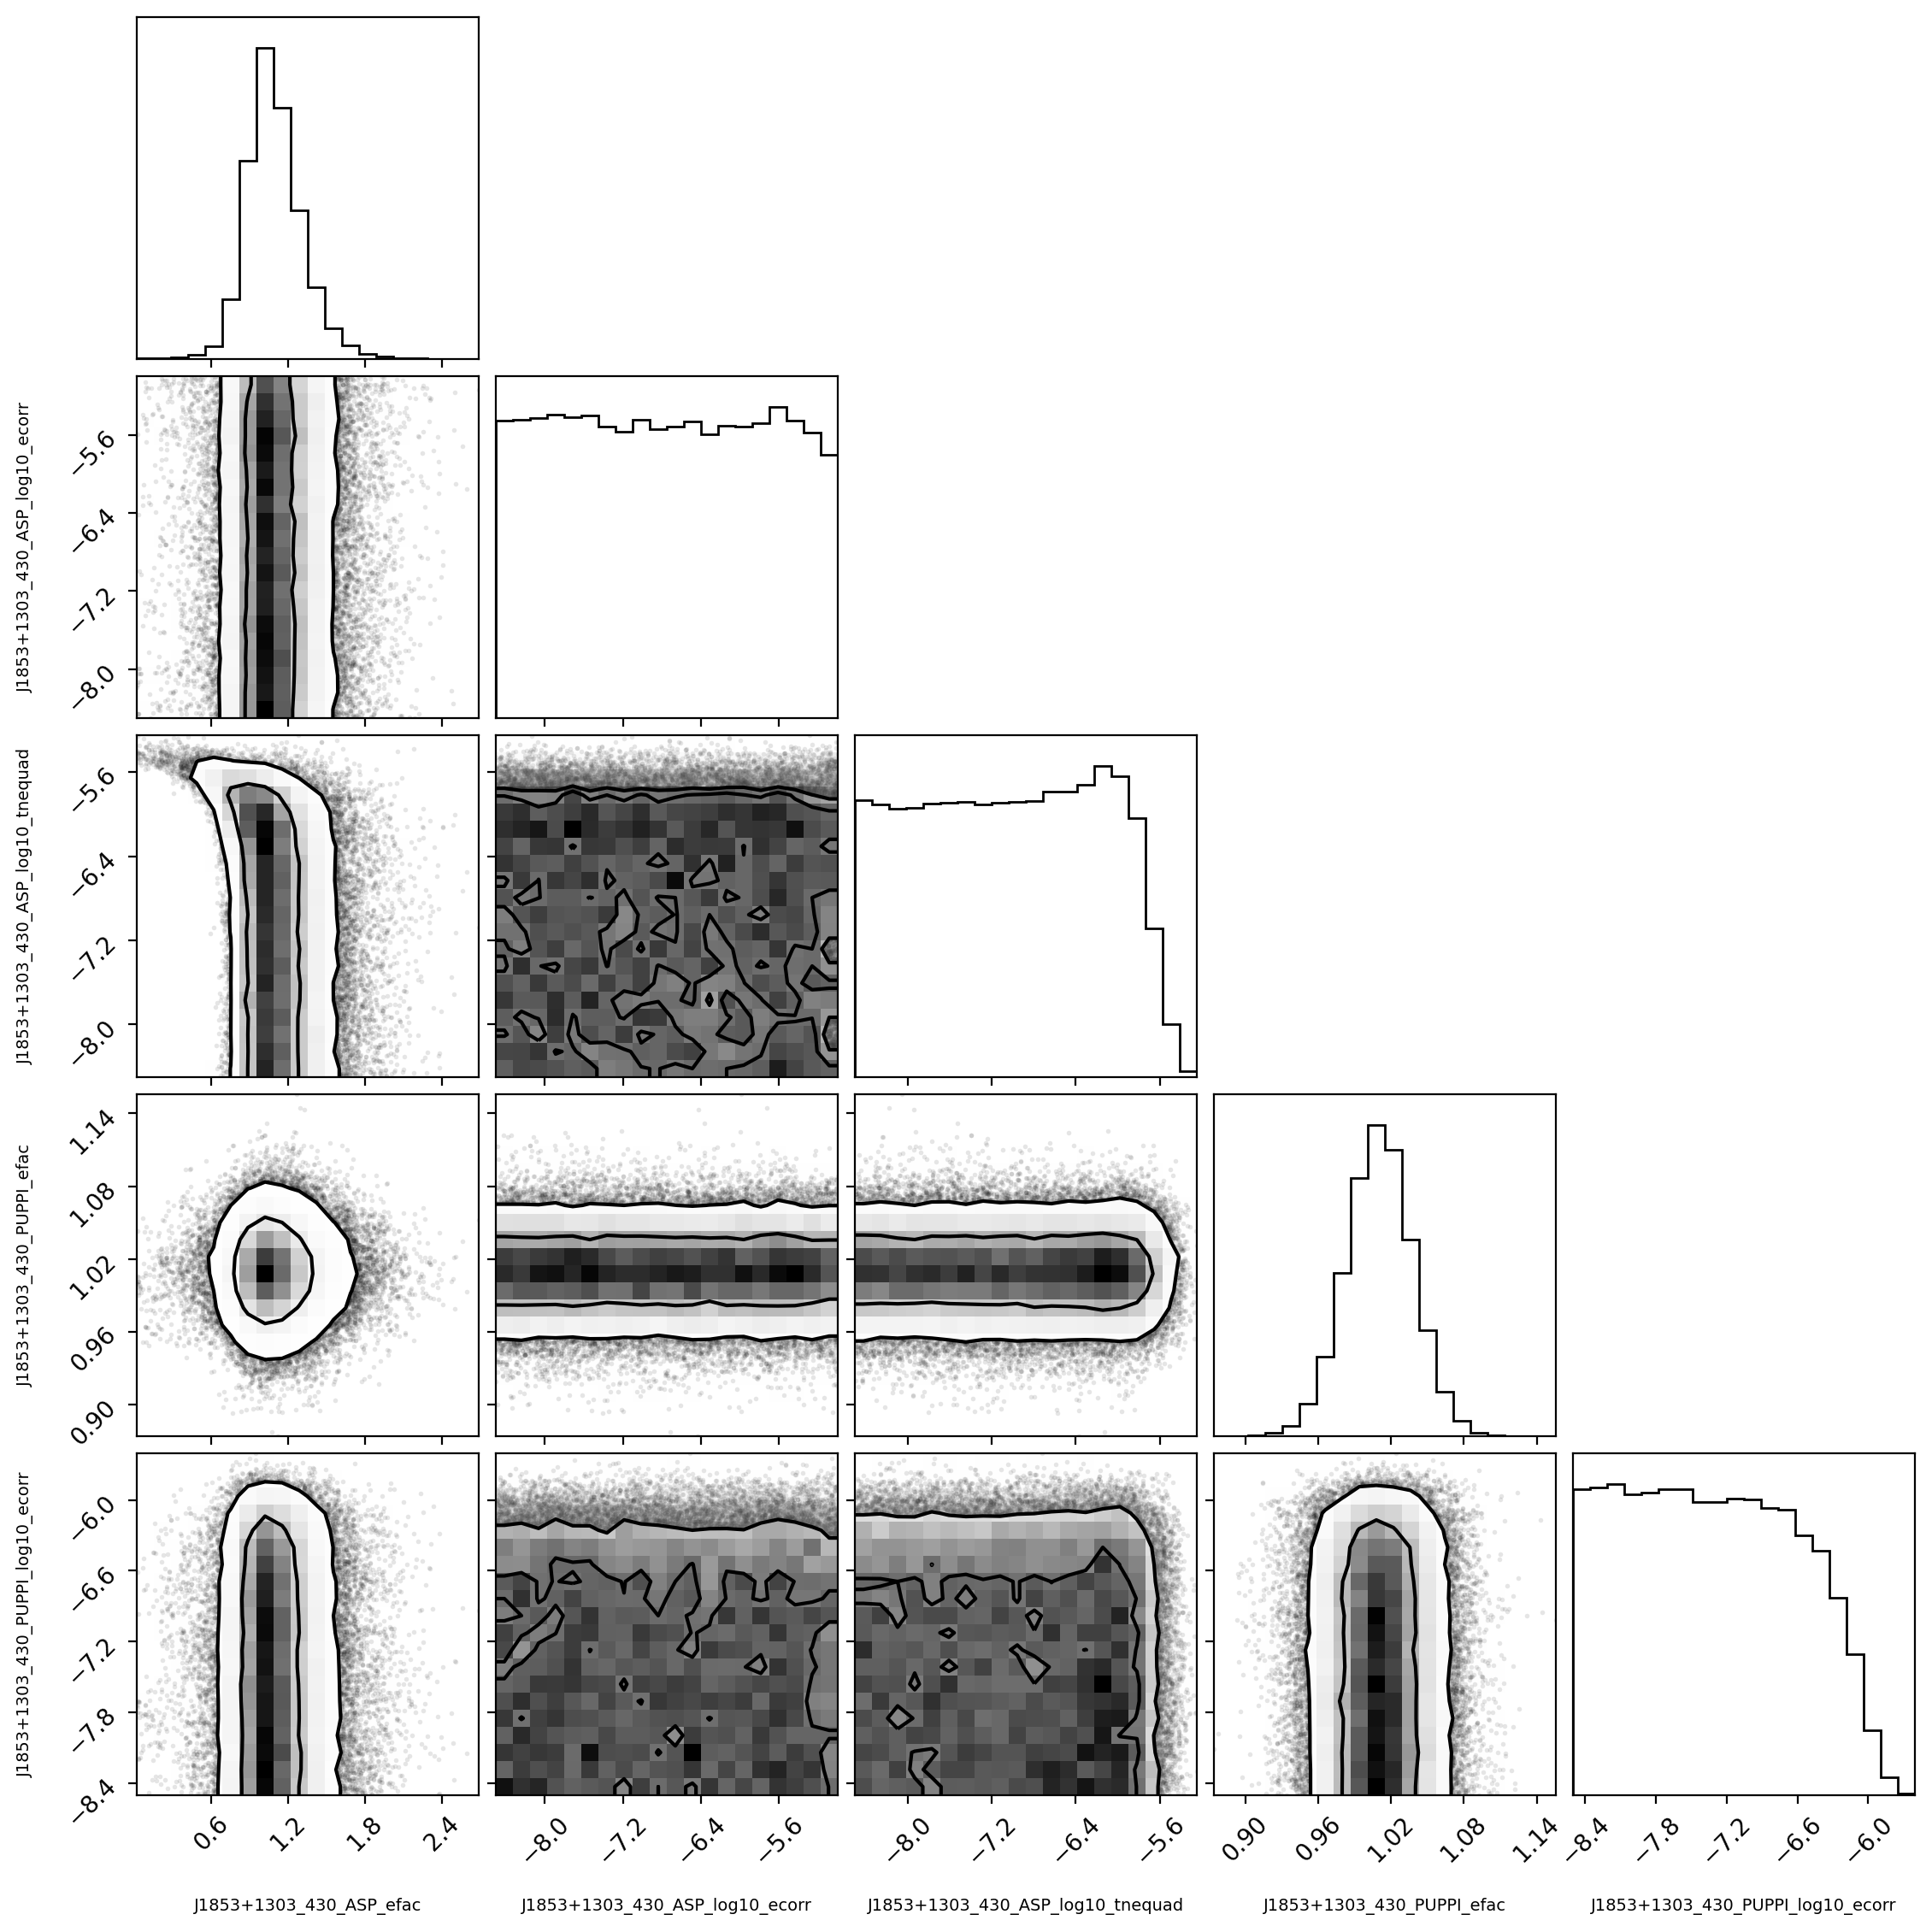

In [22]:
# Make 2d histogram plot for white noise for the PUPPI backend
ind_end = list(pta.param_names).index(psrstring + '_430_PUPPI_log10_tnequad')
fig = corner.corner(chain[burn:, np.arange(ind_end)],
                    labels=list(pta.param_names[0:ind_end]),
                    label_kwargs={"fontsize": 7},
                    levels=[0.68,0.95]);

## Now, the easy way to do all of this

* Many of us have created shortcuts to carry out these tasks. You will find them in `enterprise_extensions`: https://github.com/nanograv/enterprise_extensions.
* Note that if you decide to do it this way on your own, you will still need the imported packages above.
* Setting the data directory and creating the `Pulsar` object is also required.

In [23]:
from enterprise_extensions import models, sampler

## TNEQUAD vs T2EQUAD

* In data sets produced after the IPTA DR2 GWB analysis, the convention changed to be consistent between timing analyses and GWB analyses: TNEQUAD is used in the 12.5 year GWB analysis and IPTA DR2, while T2EQUAD is used after these analyses.

* The change amounts to changing the definition from TNEQUAD $\rightarrow$ T2EQUAD: $F^2 (\sigma_\mathrm{TOA}^2) + Q^2 \rightarrow F^2 (\sigma_\mathrm{TOA}^2 + Q^2)$ where $F$ is the EFAC parameter, $Q$ is EQUAD and $\sigma$ are the TOA errors

In [24]:
# Create a single pulsar model
pta = models.model_singlepsr_noise(psr, red_var=True, psd='powerlaw', 
                                   noisedict=None, white_vary=True, 
                                   tm_svd=True, components=30,
                                   tnequad=True)

In [25]:
# Setup a sampler instance.
# This will add some fanicer stuff than before, like prior draws, 
# and custom sample groupings.
sampler = sampler.setup_sampler(pta, outdir=outdir, resume=False)

Adding red noise prior draws...



In [27]:
# sampler for N steps
N = int(5e6)
x0 = np.hstack([p.sample() for p in pta.params])

# SCAM = Single Component Adaptive Metropolis
# AM = Adaptive Metropolis
# DE = Differential Evolution
## You can keep all these set at default values
# uncomment the following to sample (it will take a while)
# sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

* Once sampling has finished, post-processing can continue as above.
* We typically extract the median posterior values from these noise runs for white noise parameters

* This covers the white noise analysis for a single pulsar!
* Next, we move on to the Bayesian analysis of the common red noise process. 
* In the common red noise process analysis we will fix the white noise parameters to their most likely values according to single pulsar white noise runs as performed above.
* These values have been stored in a dictionary in the `channelized_12p5yr_v3_full_noisedict.json` file for the entire PTA.